In [63]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
plt.style.use('seaborn')
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split

from feat_to_model_eval import feat_to_model_kfold_eval, predict_from_line
from haversine import distance_from_flatiron

In [23]:
%reload_ext autoreload
%autoreload 2

In [24]:
df = pd.read_csv('kc_house_data.csv')

In [68]:
df, df_holdout = train_test_split(df, test_size=0.15)             
       # KEEPING A 15% HOLDOUT OF PRETEND UNSEEN DATA FOR VALIDATION
        # THE ANSWER IS CROSS VALIDATION - MOSSY THE DATA DOG

In [69]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,coords,dist_flatiron,log_dist_flatiron
20501,2781280230,1/28/2015,292000.0,3,2.50,1610,3848,2.0,0.0,0.0,...,0,0,0,0,0,0,0,"(47.4497, -122.188)",21.042711,3.046554
1208,8585400135,11/5/2014,585000.0,4,1.75,1760,5356,1.0,0.0,0.0,...,0,0,0,0,0,0,0,"(47.679, -122.288)",8.440407,2.133030
1383,3342700465,1/23/2015,250000.0,3,1.50,2840,10182,1.0,0.0,0.0,...,0,0,0,0,0,0,0,"(47.524, -122.2)",14.017552,2.640310
1179,3210950510,9/4/2014,535000.0,3,1.00,1330,40259,1.0,0.0,0.0,...,0,0,0,0,0,0,0,"(47.552, -121.89)",34.084118,3.528832
21273,3448740430,9/25/2014,392000.0,5,2.50,2340,5670,2.0,0.0,0.0,...,0,0,0,0,0,0,0,"(47.4913, -122.152)",19.135914,2.951567


In [70]:
df_holdout.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,coords,dist_flatiron,log_dist_flatiron
2648,1687000200,4/10/2015,259000.0,3,2.50,2153,4400,2.0,0.0,0.0,...,0,0,0,0,0,0,0,"(47.2872, -122.283)",36.155078,3.587817
20731,2926049582,4/12/2015,265000.0,2,1.50,1084,3427,2.0,0.0,0.0,...,0,0,0,0,0,0,0,"(47.7117, -122.326)",11.293777,2.424252
8349,5151200215,12/12/2014,585000.0,4,2.50,2430,6766,2.0,0.0,0.0,...,0,0,1,0,0,0,0,"(47.7294, -122.358)",13.337660,2.590592
8011,2596300035,4/22/2015,342000.0,4,1.00,1390,9023,1.5,0.0,0.0,...,0,0,0,0,0,0,0,"(47.7754, -122.296)",18.595391,2.922914
19469,5267000180,8/21/2014,299000.0,3,2.25,2540,9961,1.0,0.0,0.0,...,0,0,0,0,0,0,0,"(47.41, -122.208)",24.268052,3.189161


### CRISP DM
### STEP 1: Data Understanding

In [26]:
# Lets look at the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18357 entries, 9659 to 12511
Data columns (total 21 columns):
id               18357 non-null int64
date             18357 non-null object
price            18357 non-null float64
bedrooms         18357 non-null int64
bathrooms        18357 non-null float64
sqft_living      18357 non-null int64
sqft_lot         18357 non-null int64
floors           18357 non-null float64
waterfront       16348 non-null float64
view             18299 non-null float64
condition        18357 non-null int64
grade            18357 non-null int64
sqft_above       18357 non-null int64
sqft_basement    18357 non-null object
yr_built         18357 non-null int64
yr_renovated     15065 non-null float64
zipcode          18357 non-null int64
lat              18357 non-null float64
long             18357 non-null float64
sqft_living15    18357 non-null int64
sqft_lot15       18357 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.1+ MB


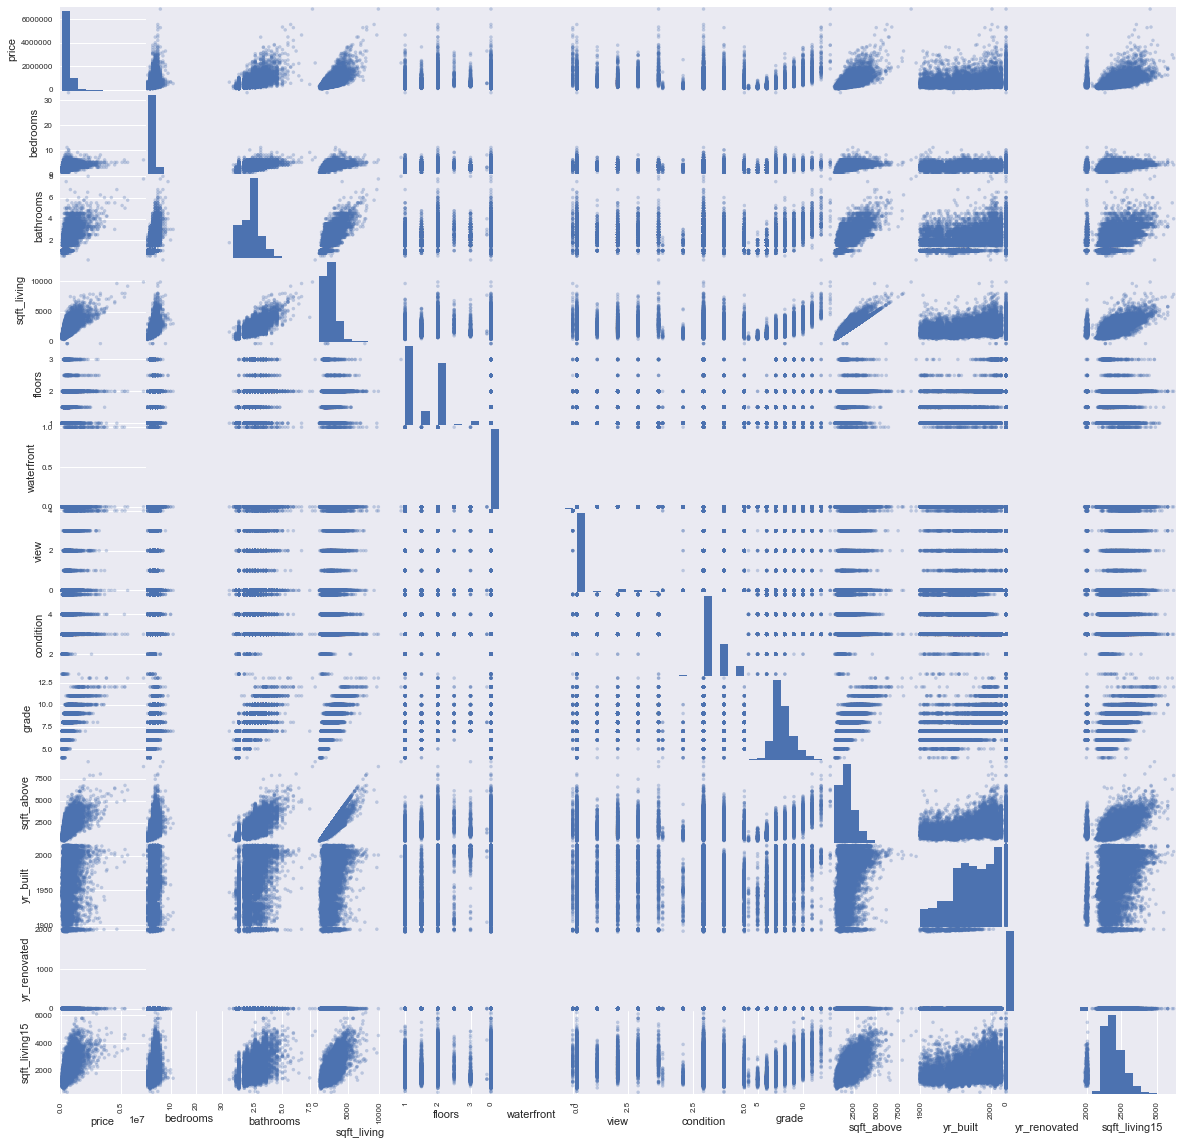

In [27]:
pd.plotting.scatter_matrix(df.drop(['id', 'date', 'sqft_basement', 'lat', 'long', 'zipcode', 'sqft_lot', 'sqft_lot15'], axis=1), figsize=(20, 20), alpha=0.3)
plt.show()

In [28]:
# LETS PICK A FEW A STRONG CANDIDATES! HOW ABOUT SQFT LIVING, SQFT LIVING 15, BATHROOM, WATERFRONT, GRADE
temp = df[['price', 'sqft_living', 'sqft_living15', 'bathrooms', 'waterfront', 'grade']]
temp.corr().price[1:]

sqft_living      0.700617
sqft_living15    0.590322
bathrooms        0.528237
waterfront       0.278290
grade            0.672908
Name: price, dtype: float64

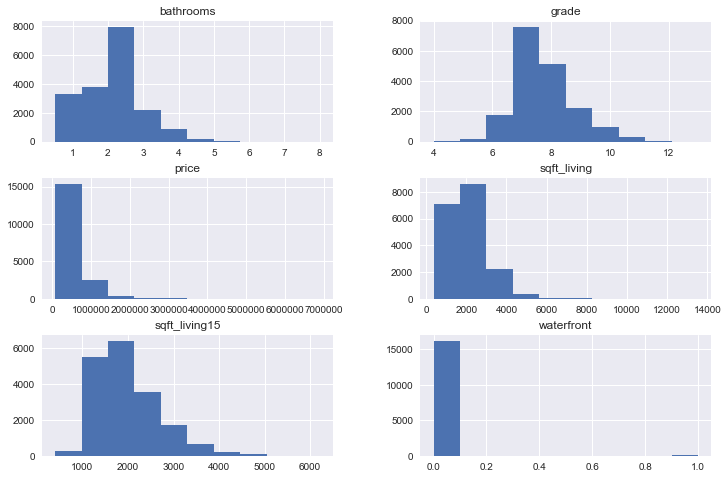

In [29]:
temp.hist(figsize=(12,8))
plt.show()

In [30]:
log_df = pd.DataFrame([])
for col in temp.drop(['waterfront'], axis=1):
    log_df[f'log_{col}'] = np.log(temp[col])
log_df.head()

,log_price,log_sqft_living,log_sqft_living15,log_bathrooms,log_grade
9659,13.374527,7.762171,7.749322,0.916291,2.197225
9544,14.403297,8.569786,8.174703,1.178655,2.302585
14770,12.520701,7.358831,7.426549,0.810930,2.079442
5829,13.011432,7.073270,6.887553,0.000000,1.945910
11150,12.948010,7.414573,7.615791,0.559616,2.079442


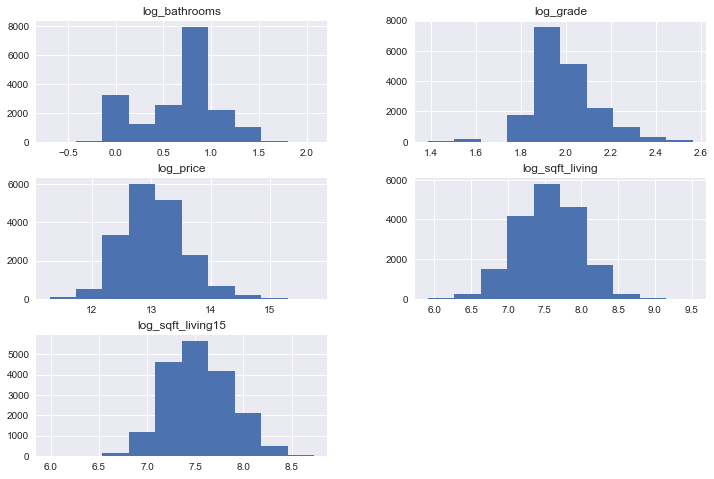

In [31]:
log_df.hist(figsize=(12,8))
plt.show()

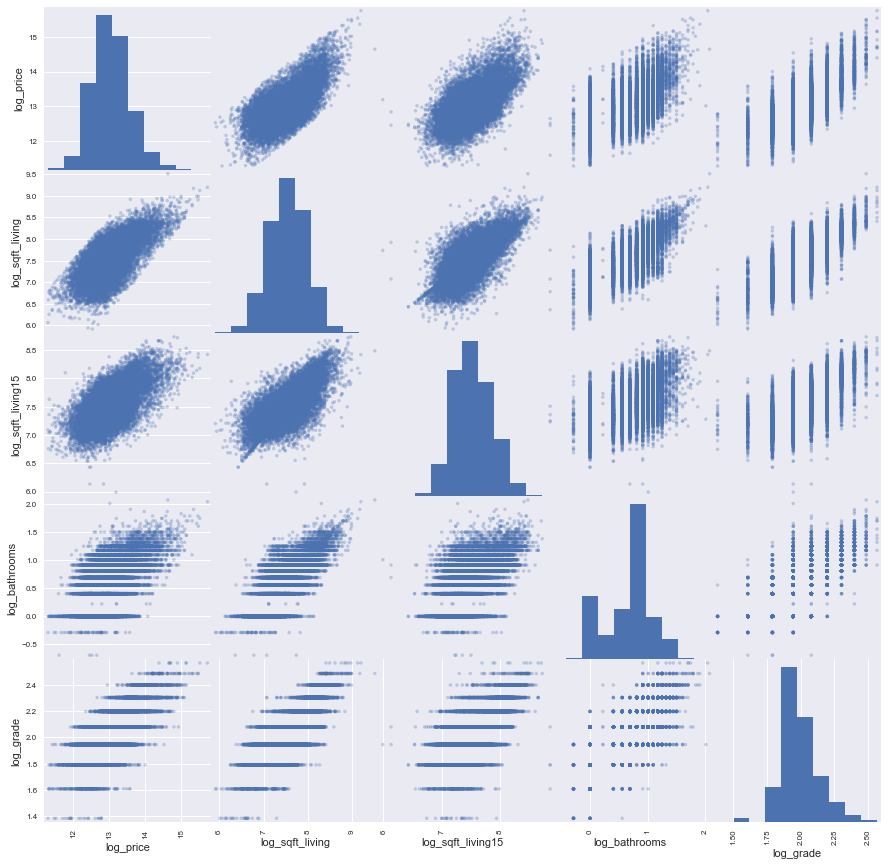

In [32]:
pd.plotting.scatter_matrix(log_df, figsize=(15,15), alpha=0.3)
plt.show()

In [33]:
log_df.corr().log_price

log_price            1.000000
log_sqft_living      0.676026
log_sqft_living15    0.608817
log_bathrooms        0.519517
log_grade            0.694606
Name: log_price, dtype: float64

In [34]:
# Lets add these to the dataframe
df = pd.concat((df, log_df), axis=1)

In [35]:
# Looks awesome! Lets check a couple other features!
df.zipcode.unique(), df.zipcode.dtype

(array([98008, 98040, 98092, 98103, 98011, 98007, 98077, 98070, 98004,
        98006, 98136, 98019, 98074, 98059, 98010, 98126, 98034, 98146,
        98144, 98042, 98188, 98002, 98052, 98058, 98116, 98031, 98102,
        98199, 98053, 98065, 98105, 98022, 98023, 98056, 98125, 98177,
        98029, 98001, 98027, 98115, 98117, 98030, 98075, 98072, 98028,
        98168, 98133, 98106, 98033, 98155, 98045, 98178, 98166, 98055,
        98198, 98122, 98005, 98038, 98024, 98118, 98112, 98119, 98003,
        98014, 98108, 98148, 98107, 98032, 98109, 98039]), dtype('int64'))

In [36]:
# Categorical  Lets Make Dummies
zip_dummies = pd.get_dummies((df.zipcode), prefix='zip')

In [37]:
zip_dummies.columns

Index(['zip_98001', 'zip_98002', 'zip_98003', 'zip_98004', 'zip_98005',
       'zip_98006', 'zip_98007', 'zip_98008', 'zip_98010', 'zip_98011',
       'zip_98014', 'zip_98019', 'zip_98022', 'zip_98023', 'zip_98024',
       'zip_98027', 'zip_98028', 'zip_98029', 'zip_98030', 'zip_98031',
       'zip_98032', 'zip_98033', 'zip_98034', 'zip_98038', 'zip_98039',
       'zip_98040', 'zip_98042', 'zip_98045', 'zip_98052', 'zip_98053',
       'zip_98055', 'zip_98056', 'zip_98058', 'zip_98059', 'zip_98065',
       'zip_98070', 'zip_98072', 'zip_98074', 'zip_98075', 'zip_98077',
       'zip_98092', 'zip_98102', 'zip_98103', 'zip_98105', 'zip_98106',
       'zip_98107', 'zip_98108', 'zip_98109', 'zip_98112', 'zip_98115',
       'zip_98116', 'zip_98117', 'zip_98118', 'zip_98119', 'zip_98122',
       'zip_98125', 'zip_98126', 'zip_98133', 'zip_98136', 'zip_98144',
       'zip_98146', 'zip_98148', 'zip_98155', 'zip_98166', 'zip_98168',
       'zip_98177', 'zip_98178', 'zip_98188', 'zip_98198', 'zip_

In [38]:
# THATS MORE LIKE IT! Lets add these as well!
df = pd.concat((df, zip_dummies), axis=1)

In [39]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'log_price',
       'log_sqft_living', 'log_sqft_living15', 'log_bathrooms', 'log_grade',
       'zip_98001', 'zip_98002', 'zip_98003', 'zip_98004', 'zip_98005',
       'zip_98006', 'zip_98007', 'zip_98008', 'zip_98010', 'zip_98011',
       'zip_98014', 'zip_98019', 'zip_98022', 'zip_98023', 'zip_98024',
       'zip_98027', 'zip_98028', 'zip_98029', 'zip_98030', 'zip_98031',
       'zip_98032', 'zip_98033', 'zip_98034', 'zip_98038', 'zip_98039',
       'zip_98040', 'zip_98042', 'zip_98045', 'zip_98052', 'zip_98053',
       'zip_98055', 'zip_98056', 'zip_98058', 'zip_98059', 'zip_98065',
       'zip_98070', 'zip_98072', 'zip_98074', 'zip_98075', 'zip_98077',
       'zip_98092', 'zip_98102', 'zip_98103', 'zip_98105', 'z

In [40]:
# Lets try a model w zips
zip_predictors = list(zip_dummies.columns)

In [41]:
feat_to_model_kfold_eval('log_price', predictors=zip_predictors, df=df, kvals=[5, 10], show_summary=True, price_logged=True, MAE=True)
print()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     300.0
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        17:51:16   Log-Likelihood:                -7309.3
No. Observations:               18357   AIC:                         1.476e+04
Df Residuals:                   18287   BIC:                         1.531e+04
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.8762      0.003   4204.866      0.000      12.870      12.882
zip_98001     -0.3818      0.020    -18.853      0.000      -0.422      -0.342
zip_98002     -0.5296      0.028    -19.226      0.000      -0.584      -0.476
zip_98003     -0.3336      0.023    -14.367      0.000      -0.379      -0.288
zip_98004      1.1140      0.022     51.569      0.000       1.072       1.156
zip_98005      0.6945      0.031     22.728      0.000       0.635       0.754
zip_98006      0.6937      0.017     39.834      0.000       0.660       0.728
zip_98007      0.4041      0.032     12.637      0.000       0.341       0.467
zip_98008      0.3963      0.023     17.133      0.000       0.351       0.442
zip_98010  -2.225e-05      0.038     -0.001      1.000      -0.075       0.075
zip_98011      0.2058      0.028      7.315      0.000       0.151       0.261
zip_98014      0.0342      0.034      0.998      0.318      -0.033       0.101
zip_98019      0.0565      0.029      1.965      0.049       0.000       0.113
zip_98022     -0.2612      0.026    -10.175      0.000      -0.311      -0.211
zip_98023     -0.3629      0.018    -20.390      0.000      -0.398      -0.328
zip_98024      0.2786      0.043      6.486      0.000       0.194       0.363
zip_98027      0.3756      0.019     19.710      0.000       0.338       0.413
zip_98028      0.1129      0.023      4.921      0.000       0.068       0.158
zip_98029      0.4085      0.022     18.675      0.000       0.366       0.451
zip_98030     -0.3063      0.025    -12.492      0.000      -0.354      -0.258
zip_98031     -0.2955      0.024    -12.540      0.000      -0.342      -0.249
zip_98032     -0.4717      0.034    -13.781      0.000      -0.539      -0.405
zip_98033      0.6162      0.019     32.159      0.000       0.579       0.654
zip_98034      0.2074      0.017     12.345      0.000       0.174       0.240
zip_98038     -0.1118      0.016     -6.915      0.000      -0.143      -0.080
zip_98039      1.6272      0.055     29.585      0.000       1.519       1.735
zip_98040      1.0555      0.023     45.167      0.000       1.010       1.101
zip_98042     -0.2771      0.017    -16.425      0.000      -0.310      -0.244
zip_98045      0.0340      0.025      1.342      0.180      -0.016       0.084
zip_98052      0.4598      0.016     28.176      0.000       0.428       0.492
zip_98053      0.4868      0.019     25.264      0.000       0.449       0.525
zip_98055     -0.2992      0.024    -12.451      0.000      -0.346      -0.252
zip_98056      0.0030      0.019      0.153      0.878      -0.035       0.041
zip_98058     -0.1532      0.018     -8.394      0.000      -0.189      -0.117
zip_98059      0.1667      0.018      9.220      0.000       0.131       0.202
zip_98065      0.2488      0.022     11.102      0.000       0.205       0.293
zi

Line: [ 1.28761616e+01 -3.81823889e-01 -5.29612532e-01 -3.33649692e-01
  1.11395125e+00  6.94537305e-01  6.93670862e-01  4.04118558e-01
  3.96265259e-01 -2.22517441e-05  2.05753640e-01  3.41684819e-02
  5.64957718e-02 -2.61176747e-01 -3.62920830e-01  2.78579607e-01
  3.75620102e-01  1.12897186e-01  4.08493272e-01 -3.06304689e-01
 -2.95496274e-01 -4.71666788e-01  6.16218989e-01  2.07429714e-01
 -1.11756337e-01  1.62717271e+00  1.05545721e+00 -2.77142178e-01
  3.40113503e-02  4.59782284e-01  4.86782253e-01 -2.99172945e-01
  2.95162729e-03 -1.53248700e-01  1.66682009e-01  2.48794572e-01
  1.72015934e-01  3.10113870e-01  5.12717150e-01  6.67746442e-01
  5.02468284e-01 -2.14590628e-01  6.45104258e-01  3.43516341e-01
  6.77593979e-01 -2.54389701e-01  3.47972162e-01 -1.40700991e-01
  7.29680192e-01  8.95911060e-01  4.09504293e-01  3.82733525e-01
  3.42252747e-01 -3.26808477e-02  6.88891734e-01  4.13995749e-01
  1.28305176e-01  2.04788446e-02 -3.78264861e-02  2.62779734e-01
  2.77467898e-01 -2

In [43]:
# LETS SEE WHAT EXTRA K FOLDS DOES??
feat_to_model_kfold_eval('log_price', predictors=zip_predictors, df=df, kvals=[5, 10, 20, 40], price_logged=True, MAE=True)
print()

Line: [ 1.28761616e+01 -3.81823889e-01 -5.29612532e-01 -3.33649692e-01
  1.11395125e+00  6.94537305e-01  6.93670862e-01  4.04118558e-01
  3.96265259e-01 -2.22517441e-05  2.05753640e-01  3.41684819e-02
  5.64957718e-02 -2.61176747e-01 -3.62920830e-01  2.78579607e-01
  3.75620102e-01  1.12897186e-01  4.08493272e-01 -3.06304689e-01
 -2.95496274e-01 -4.71666788e-01  6.16218989e-01  2.07429714e-01
 -1.11756337e-01  1.62717271e+00  1.05545721e+00 -2.77142178e-01
  3.40113503e-02  4.59782284e-01  4.86782253e-01 -2.99172945e-01
  2.95162729e-03 -1.53248700e-01  1.66682009e-01  2.48794572e-01
  1.72015934e-01  3.10113870e-01  5.12717150e-01  6.67746442e-01
  5.02468284e-01 -2.14590628e-01  6.45104258e-01  3.43516341e-01
  6.77593979e-01 -2.54389701e-01  3.47972162e-01 -1.40700991e-01
  7.29680192e-01  8.95911060e-01  4.09504293e-01  3.82733525e-01
  3.42252747e-01 -3.26808477e-02  6.88891734e-01  4.13995749e-01
  1.28305176e-01  2.04788446e-02 -3.78264861e-02  2.62779734e-01
  2.77467898e-01 -2

In [44]:
# LETS TRY THE LOGS
log_predictors = list(log_df.drop(['log_price'], axis=1).columns)
feat_to_model_kfold_eval('log_price', predictors=log_predictors, df=df, kvals=[5, 10], price_logged=True, MAE=True)
print()

Line: [ 5.57627974  0.4197905   0.18985562 -0.10134835  1.45183969]
RMSE: 251700.30328709344
MAE: 152309.86989969038
MAE DISPLAYED



In [45]:
# WHAT ABOUT LOG AND ZIPS?
zip_log_predictors = zip_predictors + log_predictors
feat_to_model_kfold_eval('log_price', predictors=zip_log_predictors, df=df, kvals=[5, 10], price_logged=True, MAE=True)
print()

Line: [ 6.14973555e+00 -4.00388981e-01 -3.78663920e-01 -3.83543360e-01
  7.22016458e-01  3.19620793e-01  2.64980455e-01  2.22804314e-01
  2.70890854e-01 -9.27376330e-02  4.46552457e-04 -1.80165367e-02
 -8.96282750e-02 -2.42126020e-01 -4.36917494e-01  1.21925271e-01
  9.87718801e-02 -1.31026817e-02  1.53450560e-01 -3.71417980e-01
 -3.44333036e-01 -4.11339383e-01  4.00234815e-01  1.39615495e-01
 -2.50705268e-01  9.85469353e-01  5.43106741e-01 -3.29507591e-01
 -3.80931669e-02  1.98946247e-01  1.81810518e-01 -2.52239482e-01
 -4.98920177e-02 -2.46222019e-01 -6.88093695e-02 -2.25291351e-02
  1.57639327e-01  6.50353939e-02  1.32198720e-01  1.58367690e-01
  5.91479701e-02 -3.82934162e-01  5.27422980e-01  4.22408976e-01
  5.52747665e-01 -2.92967117e-02  4.42049438e-01 -4.17582755e-02
  5.99134069e-01  6.33056319e-01  4.19020080e-01  3.80593081e-01
  4.24326943e-01  8.19821015e-02  5.75498897e-01  3.96791988e-01
  1.85906677e-01  1.95436041e-01  6.32603921e-02  3.13228538e-01
  2.77542829e-01 -6

In [46]:
# WHAT AN IMPROVEMENT!!!

In [47]:
df['coords'] = list(zip(
        round(df.lat, 6), 
        round(df.long, 6)))

In [48]:
df['dist_flatiron'] = df.coords.apply(distance_from_flatiron)

In [49]:
df.dist_flatiron.head()

9659     17.108906
9544     10.275406
14770    33.593296
5829      9.407300
11150    20.915893
Name: dist_flatiron, dtype: float64

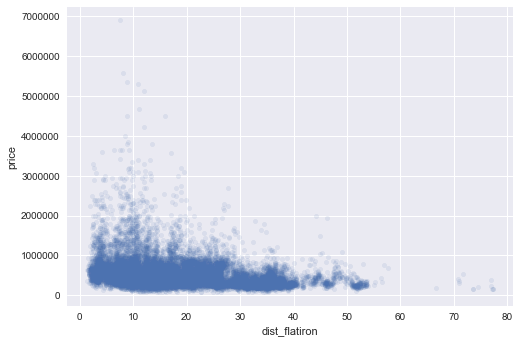

-0.35137061366026595

In [50]:
df.plot.scatter('dist_flatiron', 'price', alpha=0.1)
plt.show()
df.log_price.corr(df.dist_flatiron)

In [51]:
zip_log_dist_predictors = zip_log_predictors + ['dist_flatiron']

In [52]:
feat_to_model_kfold_eval('log_price', predictors=zip_log_dist_predictors, df=df, kvals=[5, 10], price_logged=True, MAE=True)
print()

Line: [ 6.37523471e+00 -2.29280406e-01 -1.98106169e-01 -2.22295739e-01
  6.25288409e-01  2.54675256e-01  2.28534983e-01  1.77760274e-01
  2.47964354e-01  1.47996220e-01  4.91770090e-03  1.83532310e-01
  5.76953694e-02  1.24722419e-01 -2.67989313e-01  2.80892042e-01
  1.63848534e-01 -2.64150041e-02  2.30383296e-01 -2.54605830e-01
 -2.67674480e-01 -3.21001799e-01  3.43231985e-01  1.05109107e-01
 -6.44227000e-02  8.64562439e-01  4.48257706e-01 -1.79534894e-01
  2.70191263e-01  1.93908154e-01  2.52940534e-01 -2.42001158e-01
 -8.00554193e-02 -1.95186703e-01 -5.64298201e-02  1.79447560e-01
  2.15178109e-01  1.02593892e-01  1.69484899e-01  2.15922314e-01
  1.38432077e-01 -1.78757744e-01  3.51871952e-01  2.94170111e-01
  4.20893939e-01 -1.45605012e-01  3.13129473e-01 -1.72412095e-01
  4.24761114e-01  4.63512635e-01  3.07233095e-01  2.36767178e-01
  3.16058248e-01 -3.09373220e-02  4.10080843e-01  2.17145401e-01
  1.12059342e-01  7.32949728e-02  9.38372683e-03  2.02578146e-01
  1.10978425e-01 -1

In [53]:
# WHAT IF WE NEVER LOGGED PRICE???
feat_to_model_kfold_eval('price', predictors=zip_log_dist_predictors, df=df, kvals=[5, 10], MAE=True)
print()

Line: [-3.62537222e+06 -1.89503843e+05 -1.19854855e+05 -2.05038231e+05
  4.64241373e+05 -1.14863368e+04  2.14489241e+04 -8.26358570e+04
 -1.69984180e+04 -4.52218236e+04 -1.83722224e+05 -1.39275370e+04
 -1.28421347e+05 -2.13485567e+04 -2.23987718e+05  3.31084569e+04
 -7.66664608e+04 -1.81713326e+05 -6.33115874e+04 -2.32019440e+05
 -2.39288830e+05 -2.17249642e+05  8.79733522e+04 -8.59080991e+04
 -1.65822145e+05  1.20904234e+06  3.00586281e+05 -1.91703010e+05
  3.72759809e+03 -7.92208836e+04 -2.95438428e+04 -2.11303849e+05
 -1.70372466e+05 -2.31187062e+05 -1.89882289e+05 -7.82554579e+04
 -3.09400892e+04 -1.23859056e+05 -9.08085746e+04 -4.95929440e+04
 -1.03878415e+05 -2.15852089e+05  7.76127084e+04  3.20688022e+03
  1.51526807e+05 -1.58371328e+05  5.35934428e+03 -2.04873504e+05
  1.60330946e+05  2.59249592e+05  1.51131498e+04 -2.16562423e+04
  1.23586539e+04 -1.21335079e+05  1.28575908e+05 -3.20724337e+04
 -8.50900670e+04 -9.00220013e+04 -1.34436651e+05 -4.27940990e+04
 -5.11983134e+04 -1

In [54]:
#LOG PRICE IS DOLPHINATELY BETTER... FOR SHARK
#   MAYBE LOG DISTANCE WOULD BE HELPFUL
df['log_dist_flatiron'] = np.log(df.dist_flatiron)

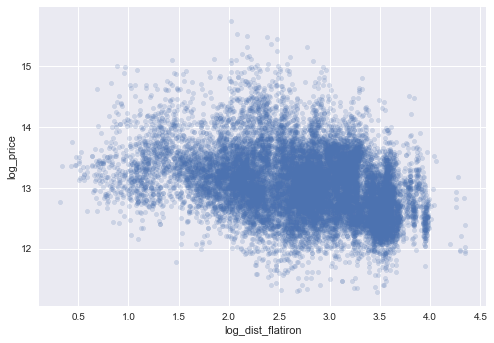

In [55]:
df.plot.scatter('log_dist_flatiron', 'log_price', alpha=0.2)

In [56]:
zip_log_logdist_predictors = zip_log_predictors + ['log_dist_flatiron']

In [57]:
feat_to_model_kfold_eval(
    'log_price', predictors=zip_log_logdist_predictors, 
    df=df, kvals=[5, 10], show_summary=True, price_logged=True, MAE=True)
print()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     1395.
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        17:52:29   Log-Likelihood:                 3124.9
No. Observations:               18357   AIC:                            -6100.
Df Residuals:                   18282   BIC:                            -5513.
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.7170      0.058    115.591      0.000       6.603       6.831
zip_98001            -0.2181      0.015    -14.426      0.000      -0.248      -0.188
zip_98002            -0.1901      0.019    -10.178      0.000      -0.227      -0.153
zip_98003            -0.2069      0.016    -12.730      0.000      -0.239      -0.175
zip_98004             0.6380      0.013     48.073      0.000       0.612       0.664
zip_98005             0.2903      0.018     16.554      0.000       0.256       0.325
zip_98006             0.2736      0.010     26.772      0.000       0.254       0.294
zip_98007             0.2226      0.018     12.262      0.000       0.187       0.258
zip_98008             0.2982      0.013     22.559      0.000       0.272       0.324
zip_98010             0.1267      0.025      5.146      0.000       0.078       0.175
zip_98011             0.0566      0.016      3.477      0.001       0.025       0.089
zip_98014             0.1729      0.022      7.870      0.000       0.130       0.216
zip_98019             0.0784      0.019      4.197      0.000       0.042       0.115
zip_98022             0.0318      0.021      1.533      0.125      -0.009       0.072
zip_98023            -0.2550      0.014    -18.105      0.000      -0.283      -0.227
zip_98024             0.2974      0.026     11.381      0.000       0.246       0.349
zip_98027             0.2079      0.012     16.764      0.000       0.184       0.232
zip_98028             0.0245      0.013      1.858      0.063      -0.001       0.050
zip_98029             0.2749      0.014     19.471      0.000       0.247       0.303
zip_98030            -0.2219      0.016    -13.803      0.000      -0.253      -0.190
zip_98031            -0.2236      0.015    -15.031      0.000      -0.253      -0.194
zip_98032            -0.2802      0.021    -13.559      0.000      -0.321      -0.240
zip_98033             0.3826      0.011     34.874      0.000       0.361       0.404
zip_98034             0.1523      0.010     15.936      0.000       0.134       0.171
zip_98038            -0.0592      0.014     -4.272      0.000      -0.086      -0.032
zip_98039             0.8488      0.032     26.355      0.000       0.786       0.912
zip_98040             0.4604      0.014     32.214      0.000       0.432       0.488
zip_98042            -0.1594      0.013    -12.015      0.000      -0.185      -0.133
zip_98045             0.2126      0.020     10.775      0.000       0.174       0.251
zip_98052             0.2449      0.010     25.231      0.000       0.226       0.264
zip_98053             0.2975      0.013     23.426      0.000       0.273       0.322
zip_98055            -0.1902      0.014    -13.550      0.000      -0.218      -0.163
zip_98056            -0.0317      0.011     -2.887      0.004      -0.053

Line: [ 6.71704816e+00 -2.18134461e-01 -1.90088759e-01 -2.06855485e-01
  6.38017683e-01  2.90278383e-01  2.73579515e-01  2.22604215e-01
  2.98219386e-01  1.26697342e-01  5.66393575e-02  1.72906609e-01
  7.84057657e-02  3.17886435e-02 -2.54978367e-01  2.97438009e-01
  2.07939058e-01  2.45329757e-02  2.74884316e-01 -2.21918719e-01
 -2.23564358e-01 -2.80185059e-01  3.82636187e-01  1.52329324e-01
 -5.91967716e-02  8.48771375e-01  4.60429118e-01 -1.59388741e-01
  2.12568012e-01  2.44944473e-01  2.97520362e-01 -1.90215713e-01
 -3.17228475e-02 -1.46532682e-01 -5.36192161e-03  1.76835514e-01
  2.59333187e-01  1.52801469e-01  2.19923447e-01  2.61907290e-01
  1.80787801e-01 -1.82160062e-01  1.78021005e-01  2.64623238e-01
  3.88899579e-01 -1.53712452e-01  2.88264010e-01 -2.03015338e-01
  2.62364410e-01  3.21726199e-01  3.05842488e-01  1.80898468e-01
  3.19767248e-01 -3.61047883e-02  2.88377192e-01  2.64844464e-02
  1.44288049e-01  5.43789756e-02  4.87486153e-02  2.01987099e-01
 -1.51108617e-02 -1

In [61]:
# NOT MUCH DIF, logbathroom is negative coef, interesting, lets try with bathrooms instead of logbathrooms
try_predictors = zip_predictors + ['log_sqft_living', 'log_sqft_living15', 'bathrooms', 'log_grade', 'log_dist_flatiron']
line, errs, rmse, mae = feat_to_model_kfold_eval(
    'log_price', predictors=try_predictors, df=df, kvals=[5, 10], 
    show_summary=True, price_logged=True,  MAE=True)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     1393.
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        17:53:22   Log-Likelihood:                 3114.6
No. Observations:               18357   AIC:                            -6079.
Df Residuals:                   18282   BIC:                            -5493.
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.9147      0.057    120.719      0.000       6.802       7.027
zip_98001            -0.2178      0.015    -14.393      0.000      -0.247      -0.188
zip_98002            -0.1906      0.019    -10.202      0.000      -0.227      -0.154
zip_98003            -0.2063      0.016    -12.687      0.000      -0.238      -0.174
zip_98004             0.6441      0.013     48.535      0.000       0.618       0.670
zip_98005             0.2947      0.018     16.793      0.000       0.260       0.329
zip_98006             0.2782      0.010     27.218      0.000       0.258       0.298
zip_98007             0.2266      0.018     12.472      0.000       0.191       0.262
zip_98008             0.3021      0.013     22.831      0.000       0.276       0.328
zip_98010             0.1278      0.025      5.188      0.000       0.080       0.176
zip_98011             0.0576      0.016      3.533      0.000       0.026       0.090
zip_98014             0.1743      0.022      7.929      0.000       0.131       0.217
zip_98019             0.0756      0.019      4.042      0.000       0.039       0.112
zip_98022             0.0319      0.021      1.539      0.124      -0.009       0.073
zip_98023            -0.2540      0.014    -18.021      0.000      -0.282      -0.226
zip_98024             0.2994      0.026     11.451      0.000       0.248       0.351
zip_98027             0.2075      0.012     16.717      0.000       0.183       0.232
zip_98028             0.0270      0.013      2.047      0.041       0.001       0.053
zip_98029             0.2707      0.014     19.169      0.000       0.243       0.298
zip_98030            -0.2239      0.016    -13.922      0.000      -0.255      -0.192
zip_98031            -0.2258      0.015    -15.177      0.000      -0.255      -0.197
zip_98032            -0.2742      0.021    -13.265      0.000      -0.315      -0.234
zip_98033             0.3853      0.011     35.100      0.000       0.364       0.407
zip_98034             0.1533      0.010     16.031      0.000       0.135       0.172
zip_98038            -0.0641      0.014     -4.628      0.000      -0.091      -0.037
zip_98039             0.8517      0.032     26.438      0.000       0.789       0.915
zip_98040             0.4653      0.014     32.555      0.000       0.437       0.493
zip_98042            -0.1608      0.013    -12.119      0.000      -0.187      -0.135
zip_98045             0.2124      0.020     10.761      0.000       0.174       0.251
zip_98052             0.2466      0.010     25.377      0.000       0.228       0.266
zip_98053             0.2986      0.013     23.493      0.000       0.274       0.323
zip_98055            -0.1886      0.014    -13.431      0.000      -0.216      -0.161
zip_98056            -0.0289      0.011     -2.629      0.009      -0.050

Line: [ 6.91470851e+00 -2.17754950e-01 -1.90645535e-01 -2.06286459e-01
  6.44085742e-01  2.94684925e-01  2.78196253e-01  2.26608302e-01
  3.02124185e-01  1.27783628e-01  5.75820157e-02  1.74284249e-01
  7.55514381e-02  3.19388147e-02 -2.53950614e-01  2.99401246e-01
  2.07479213e-01  2.70452025e-02  2.70720050e-01 -2.23920716e-01
 -2.25818195e-01 -2.74240008e-01  3.85295687e-01  1.53349910e-01
 -6.41292899e-02  8.51749595e-01  4.65257838e-01 -1.60836872e-01
  2.12412071e-01  2.46589428e-01  2.98556204e-01 -1.88647089e-01
 -2.89042918e-02 -1.44901690e-01 -4.15324420e-03  1.73629456e-01
  2.62592926e-01  1.56557718e-01  2.22436434e-01  2.63669831e-01
  1.86154121e-01 -1.82469775e-01  1.82290081e-01  2.68512875e-01
  3.93881265e-01 -1.52125805e-01  2.86497247e-01 -1.99981595e-01
  2.69115905e-01  3.28675889e-01  3.12225637e-01  1.86653162e-01
  3.25571012e-01 -3.00886213e-02  2.93107322e-01  3.08049867e-02
  1.49457348e-01  6.08372301e-02  5.41626117e-02  2.07338884e-01
 -1.06939854e-02 -9

In [59]:
# DIDN'T REALLY CHANGE MUCH



In [62]:
line

array([ 6.91470851e+00, -2.17754950e-01, -1.90645535e-01, -2.06286459e-01,
        6.44085742e-01,  2.94684925e-01,  2.78196253e-01,  2.26608302e-01,
        3.02124185e-01,  1.27783628e-01,  5.75820157e-02,  1.74284249e-01,
        7.55514381e-02,  3.19388147e-02, -2.53950614e-01,  2.99401246e-01,
        2.07479213e-01,  2.70452025e-02,  2.70720050e-01, -2.23920716e-01,
       -2.25818195e-01, -2.74240008e-01,  3.85295687e-01,  1.53349910e-01,
       -6.41292899e-02,  8.51749595e-01,  4.65257838e-01, -1.60836872e-01,
        2.12412071e-01,  2.46589428e-01,  2.98556204e-01, -1.88647089e-01,
       -2.89042918e-02, -1.44901690e-01, -4.15324420e-03,  1.73629456e-01,
        2.62592926e-01,  1.56557718e-01,  2.22436434e-01,  2.63669831e-01,
        1.86154121e-01, -1.82469775e-01,  1.82290081e-01,  2.68512875e-01,
        3.93881265e-01, -1.52125805e-01,  2.86497247e-01, -1.99981595e-01,
        2.69115905e-01,  3.28675889e-01,  3.12225637e-01,  1.86653162e-01,
        3.25571012e-01, -

In [ ]:
# WHAT PRETTY COEFFICIENTS!!!!